# EE769 Project - Galax-See
### Harshda Saxena, Vaishnav V Rao, Nabeel Ahmed, Friedrika Biffar

Analyze the images of galaxies from the SDSS catalogue to find automated metrics that reproduce the probability that a specific galaxy belongs in a particular class based on its morphology. These classes measure the shape, orientation, pattern, arm and central bulge structure, and other distinct features in a galaxy. 




First, we use similar code from Assignment 2 to visualize the kind of data we have, and to plot some images
## Chapter 1: Visualize Some Images

In [3]:
#Import important packages
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Define the path to the directory containing the images
directory_path = "data/images_training_rev1"

# Define the file extension of the images
file_extension = "*.jpg"

# Create a list of all image file names
train_image_names = glob.glob(os.path.join(directory_path, file_extension))

In [5]:
from PIL import Image
import random
import matplotlib.pyplot as plt

#Define function to plot some galaxies
def plotsomegalaxies(path, sample=5):
    random_image = random.sample(os.listdir(path), sample) #Import sample number of images randomly from the path
    plt.figure(figsize=(16, 5))
    for i in range(sample): #Plot them
        plt.subplot(1, sample, i+1)
        img = Image.open(os.path.join(path, random_image[i]))
        plt.imshow(img)
        plt.axis(False)

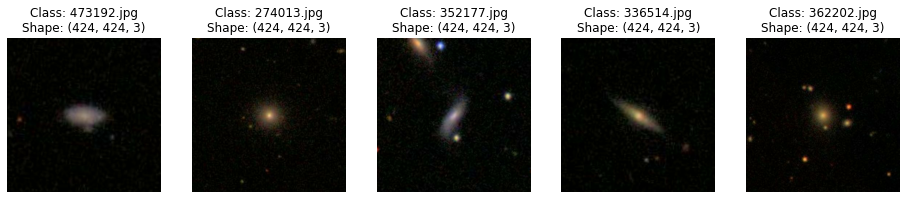

In [8]:
plot_random_galaxy(directory_path)

We see that there are a wide range of types of galaxies/other sky objects which have been detected, and our aim is to find the most accurate models to classify them into certain types. The classification classes are shown below - 

![alternatvie text](https://storage.googleapis.com/kaggle-competitions/kaggle/3175/media/Screen%20Shot%202013-09-25%20at%2010.15.06.png)

In a pictorial format, this looks like - 
![alternatvie text](https://storage.googleapis.com/kaggle-competitions/kaggle/3175/media/Screen%20Shot%202013-09-25%20at%2010.08.17.png)

## Chapter 2: Extract some features and run some well known models on it

Here, we extract features using resnet 18, and train some well known and models that we studied in class to see how such models perform on extracted features of images. The target data consists of 37 classes, and the probability of belonging to those classes. The details of the classification are as follows - 

### 2.1 Extract the features, and store it in a CSV

In [1]:
# CODE FOR EXTRACTING FEATURES. TAKES V LONG TO RUN - Run once and store the extracted features into a CSV
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18

# Define the path to your image folder
data_path = 'data/images_training_rev1'

# Define a transform to apply to each image
transform = transforms.Compose([
    transforms.Resize(256),  # resize the image to 256x256
    transforms.CenterCrop(224),  # crop the image to 224x224 at the center
    transforms.ToTensor(),  # convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the image
])

# Define a function to read the image file
def default_loader(path):
    return Image.open(path).convert('RGB')

# Get the list of image file names
image_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

# Define a PyTorch dataloader to load the images in batches
dataloader = torch.utils.data.DataLoader(image_files, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

# Remove the last fully connected layer to get the 512 features
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# Set the model to evaluation mode
resnet.eval()

# Extract features for each batch of images using ResNet18
features = []
for batch in dataloader:
    images = [default_loader(f) for f in batch]
    images = torch.stack([transform(image) for image in images])
    with torch.no_grad():
        batch_features = resnet(images)
    batch_features = batch_features.view(batch_features.size(0), -1)
    features.append(batch_features.numpy())

# Concatenate the features for all batches into one array
features = np.concatenate(features, axis=0)


D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
np.savetxt('features.csv',features, delimiter = ',') #Save into a csv

In [1]:
import pandas as pd

target_df= pd.read_csv('data/training_solutions_rev1.csv') #Read the target vectors of the training data
train_target=target_df[target_df.columns[1:]].values #Remove the column of Galaxy ID's
print(train_target.shape)
train_target=train_target[1:] #Remove the column of Galaxy ID's

data_df= pd.read_csv('features.csv') #Read the feauters of the training data
data_matrix= data_df.values
print(data_matrix.shape)

(61578, 37)
(61577, 512)


### 2.2 Run a Random Forest Multi-Output Regressor

In [2]:
# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_matrix,train_target, test_size=0.2)

In [3]:
#Import GridSearchCV to find the best possible hyperparameters for these features
from sklearn.model_selection import GridSearchCV, KFold

In [7]:
#use scikit-learn's MultiOutputRegressor class to perform multi-output regression using an underlying regression model such as Random Forest.
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#max_depth is the maximum depth of each decision tree in the forest
#max_features is the maximum number of features that the algorithm is allowed to use to split a node in a decision tree. 
hyperparam_grid = {'estimator__max_depth': [1, 5, 10, 15, 20],'estimator__max_features': [1,2,5]} 

# create the Random Forest regressor
rf = RandomForestRegressor(criterion='mse')

# create the MultiOutputRegressor with Random Forest as the underlying regressor
mor = MultiOutputRegressor(rf)

# perform grid search with cross-validation to find the best hyperparameters
mor_gridsearch = GridSearchCV(mor, param_grid=hyperparam_grid, cv=five_fold)
mor_gridsearch.fit(X_train, y_train)

# get the best MultiOutputRegressor model
mor_best = mor_gridsearch.best_estimator_

# make predictions on training data and evaluate the R-squared score
#R² = 1 - (SS_res / SS_tot)
# SS_res is the sum of squared residuals, and SS_tot is the total sum of squares
mor_pred_train = mor_best.predict(X_train)
r2_train = r2_score(y_train, mor_pred_train, multioutput='variance_weighted')

# make predictions on testing data and evaluate the R-squared score
mor_pred_test = mor_best.predict(X_test)
r2_test = r2_score(y_test, mor_pred_test, multioutput='variance_weighted')

# print the best hyperparameters and R-squared scores
print("Best parameters: ", mor_gridsearch.best_params_)
print("R-squared score for MultiOutputRegressor on training data: ", r2_train)
print("R-squared score for MultiOutputRegressor on testing data: ", r2_test)


Best parameters:  {'estimator__max_depth': 20, 'estimator__max_features': 5}
R-squared score for MultiOutputRegressor on training data:  0.854737652230796
R-squared score for MultiOutputRegressor on testing data:  0.3318437669969308


Clearly, the Random Forest, as we have seen before tends to overfit to training data with high accuracy, but has a very poor accuracy with the testing data

### 2.3 Run a Basic Bare-Bones Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the neural network architecture - a basic linear setup
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 37)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

# Define the training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss / len(train_loader)))

# Define the training data and target vector
data = torch.FloatTensor(data_matrix) # Load our data
targets = torch.FloatTensor(train_target) # Load target train

# Create the dataset and data loader
dataset = CustomDataset(data, targets)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create the neural network and optimizer
model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Loss: 0.0272
Epoch [2/50], Loss: 0.0270
Epoch [3/50], Loss: 0.0269
Epoch [4/50], Loss: 0.0269
Epoch [5/50], Loss: 0.0269
Epoch [6/50], Loss: 0.0269
Epoch [7/50], Loss: 0.0269
Epoch [8/50], Loss: 0.0269
Epoch [9/50], Loss: 0.0269
Epoch [10/50], Loss: 0.0269
Epoch [11/50], Loss: 0.0269
Epoch [12/50], Loss: 0.0269
Epoch [13/50], Loss: 0.0269
Epoch [14/50], Loss: 0.0269
Epoch [15/50], Loss: 0.0269
Epoch [16/50], Loss: 0.0269
Epoch [17/50], Loss: 0.0269
Epoch [18/50], Loss: 0.0269
Epoch [19/50], Loss: 0.0269
Epoch [20/50], Loss: 0.0269
Epoch [21/50], Loss: 0.0269
Epoch [22/50], Loss: 0.0269
Epoch [23/50], Loss: 0.0269
Epoch [24/50], Loss: 0.0269
Epoch [25/50], Loss: 0.0269
Epoch [26/50], Loss: 0.0269
Epoch [27/50], Loss: 0.0269
Epoch [28/50], Loss: 0.0269
Epoch [29/50], Loss: 0.0269
Epoch [30/50], Loss: 0.0269
Epoch [31/50], Loss: 0.0269
Epoch [32/50], Loss: 0.0269
Epoch [33/50], Loss: 0.0269
Epoch [34/50], Loss: 0.0269
Epoch [35/50], Loss: 0.0269
Epoch [36/50], Loss: 0.0269
E

Clearly, even a basic bones neural network with MSE Loss does a better job than a Random Forest or other such models, and much faster as well. This motivates us to explore neural networks, especially Convolutional Neural Netoworks (CNN) for these tasks

## Chapter 3: Run a Convolutional Neural Network in various levels of complexity

For this, we do not need to use the extracted features from resnet 18 as before, but simply load the images, and run the necessary layers

###  3.1 Run a basic single convolution layer model with 20k images

In [6]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
          
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

df = pd.read_csv('data/training_solutions_rev1.csv') 

#Only use the first 20000 images to prevent crashing , split into train validation
df_train, df_test = train_test_split(df[:20000], test_size=.2) 

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path) #Read to RGB Pixel values
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]] #Crop the image
    x = resize(x, shape) #Resize the image
    x = x/255.
    return x

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2 #Define a shape for cropping
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str) #1st column is Galaxy Ids
    y_batch = sel[:,1:] #Everything except the first column
    x_batch = []
    for i in tqdm(ids): #For each galaxy
        x = get_image('data/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x) #Add to a list of images
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train) #Split X and y train and test 
X_test, y_test = get_all_images(df_test)

100%|██████████| 4000/4000 [01:17<00:00, 51.52it/s]


In [9]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) #Define RMSE error 

#Define a sequential model
model = Sequential()

#Add a convolution layer of 512 channels, (3,3) filter size with relu activation
model.add(Conv2D(512, (3, 3), activation='relu', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))

#Max pool to decrease the size by half
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten into 1 D array
model.add(GlobalMaxPooling2D())

# Fully conneted layer for 37 outputs with sigmoid activation
model.add(Dense(37, activation='sigmoid'))

#Use cross entropy for loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', root_mean_squared_error])

#Present a model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 512)       14336     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 512)      0         
 2D)                                                             
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 37)                18981     
                                                                 
Total params: 33,317
Trainable params: 33,317
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 128
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test),use_multiprocessing=True)
#Fit the model and print loss, accuracy and RMSE

Epoch 1/5
500/500 [==============================] - 301s 602ms/step - loss: 0.2986 - accuracy: 0.6006 - root_mean_squared_error: 0.1630 - val_loss: 0.2985 - val_accuracy: 0.5987 - val_root_mean_squared_error: 0.1631
Epoch 2/5
500/500 [==============================] - 295s 591ms/step - loss: 0.2986 - accuracy: 0.6006 - root_mean_squared_error: 0.1630 - val_loss: 0.2985 - val_accuracy: 0.5987 - val_root_mean_squared_error: 0.1631
Epoch 3/5
500/500 [==============================] - 297s 593ms/step - loss: 0.2985 - accuracy: 0.6006 - root_mean_squared_error: 0.1630 - val_loss: 0.2986 - val_accuracy: 0.5987 - val_root_mean_squared_error: 0.1632
Epoch 4/5
500/500 [==============================] - 301s 602ms/step - loss: 0.2984 - accuracy: 0.6006 - root_mean_squared_error: 0.1628 - val_loss: 0.2983 - val_accuracy: 0.5987 - val_root_mean_squared_error: 0.1629
Epoch 5/5
500/500 [==============================] - 300s 600ms/step - loss: 0.2983 - accuracy: 0.6006 - root_mean_squared_error: 0.

We see that even with just a basic CNN with a single layer, we get much higher accuracy of 60% training and validation.

###  3.2 Run a multi-convolution layer model w 30k images

Now we use more images (30000) to increase the training samples, and add more convolutional layers to our model

In [2]:
df = pd.read_csv('data/training_solutions_rev1.csv')

df_train, df_test = train_test_split(df[:30000], test_size=.2)
df_train.shape, df_test.shape

((24000, 38), (6000, 38))

In [3]:
trainPath = 'data/images_training_rev1'

In [7]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
          
#Similar logic as before
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('data/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████████████████████████████████| 6000/6000 [00:57<00:00, 103.86it/s]


In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#Add 3 convolutional layers 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5)) #Add some dropout for regularization, by randomly dropping some neurons
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(37, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy', root_mean_squared_error])

model.summary()

2023-04-28 23:55:57.606382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [10]:
batch_size = 128
epochs = 20 #Run more epochs this time
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/20
188/188 [==============================] - 54s 280ms/step - loss: 0.3327 - accuracy: 0.5574 - root_mean_squared_error: 0.1875 - val_loss: 0.2994 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 2/20
188/188 [==============================] - 52s 277ms/step - loss: 0.3055 - accuracy: 0.5941 - root_mean_squared_error: 0.1686 - val_loss: 0.2993 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 3/20
188/188 [==============================] - 57s 304ms/step - loss: 0.3038 - accuracy: 0.5980 - root_mean_squared_error: 0.1671 - val_loss: 0.2992 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 4/20
188/188 [==============================] - 53s 280ms/step - loss: 0.3028 - accuracy: 0.5982 - root_mean_squared_error: 0.1662 - val_loss: 0.2993 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 5/20
188/188 [==============================] - 53s 283ms/step - loss: 0.3024 - accuracy: 0.5985 - root_mean_squared_error: 0.

We note that even with more samples, a more complicated model with more convolution layers, and more epochs, we still see a similar accuracy as before, with 60% accuracy in both training and test

### 3.3 - Train the last 2 layers of Resnet 50 

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Load ResNet50 model without the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers except the last two
for layer in resnet_model.layers[:-2]:
    layer.trainable = False

# Add the last two layers for custom classification task
x = layers.Flatten()(resnet_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(37, activation='sigmoid')(x)

# Create the final model
model = keras.Model(inputs=resnet_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy', root_mean_squared_error])

model.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                             

In [15]:
batch_size = 128
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/20
188/188 [==============================] - 184s 959ms/step - loss: 0.3289 - accuracy: 0.5235 - root_mean_squared_error: 0.1856 - val_loss: 0.2996 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1637
Epoch 2/20
188/188 [==============================] - 174s 923ms/step - loss: 0.3093 - accuracy: 0.5919 - root_mean_squared_error: 0.1707 - val_loss: 0.2993 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 3/20
188/188 [==============================] - 172s 918ms/step - loss: 0.3061 - accuracy: 0.5977 - root_mean_squared_error: 0.1679 - val_loss: 0.2992 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 4/20
188/188 [==============================] - 181s 962ms/step - loss: 0.3048 - accuracy: 0.5985 - root_mean_squared_error: 0.1668 - val_loss: 0.2991 - val_accuracy: 0.5985 - val_root_mean_squared_error: 0.1635
Epoch 5/20
188/188 [==============================] - 176s 940ms/step - loss: 0.3041 - accuracy: 0.5985 - root_mean_squared_erro

Again, we note that with a much more complicated model with more convolution and activation layers, we still see a similar accuracy as before, with 60% accuracy in both training and test. Thus, increasing more and more convolution layers for our problem is not the best way to go for increased accuracy.

## Chapter 4: Using 5-class labels to train the model

#### Instead of 37 classes, we now classify galaxies into some broad classes regarding their shape based on the following cutoffs:
- (0) completely rounded: smooth (number of votes > 0.469), completely_round (>0.469)
- (1) rounded in-between: smooth (>0.469), rounded_in_between (>0.5)
- (2) cigar-shaped: smooth (>0.469), cigar_shaped (>0.5)
- (3) edge-on: features_or_disk (>0.43), edgeon_yes (>0.602)
- (4) spiral: features_or_disk (>0.43), edgeon_no (>0.715), spiral (>0.619)

#### The target data has the relevant coloumns of:
- smooth- Class1.1
- completely_round- Class7.1
- rounded_in_between- Class7.2
- cigar_shaped- Class7.3
- features_or_disk- Class1.2
- edgeon_yes- Class2.1
- edgeon_no- Class2.2
- spiral- Class4.1

In [3]:
df = pd.read_csv('data/training_solutions_rev1.csv')
df['label'] = pd.Series(dtype='int') #Intialize a new coloumn
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,label
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512,NaN
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000,NaN
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,NaN
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000,NaN
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,NaN


In [4]:
#iterate over the rows of the dataframe to assign class labels to each row
for index, row in df.iterrows():
    #smooth class
    if (row['Class1.1']>0.469) & (row['Class7.1']>0.469):
        df.at[index, 'label'] =0
        
    #rounded in-between class
    if (row['Class1.1']>0.469) & (row['Class7.2']>0.5):
        df.at[index, 'label']=1
        
    #cigar-shaped class
    if (row['Class1.1']>0.469) & (row['Class7.3']>0.5):
        df.at[index, 'label']=2
        
    #edge-on class
    if (row['Class1.2']>0.43) & (row['Class2.1']>0.602):
        df.at[index, 'label']=3
        
    #spiral class
    if (row['Class1.2']>0.43) & (row['Class2.2']>0.715) &(row['Class4.1']>0.619):
        df.at[index, 'label']=4

In [5]:
df_filtered = df[df['label'].notna()]
df_filtered.shape

(29712, 39)

In [6]:
df_train, df_test = train_test_split(df_filtered, test_size=.2)
df_train.shape, df_test.shape

((23769, 39), (5943, 39))

In [7]:
trainPath = 'data/images_training_rev1'

In [8]:
from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline
          
#Same pre-processing of images as before 
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    #cropping and resizing
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2 #cropping parameters
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,-1] #target vector is now just one column containing 5 different integers
    x_batch = []
    for i in tqdm(ids):
        x = get_image('data/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████████████████████████████████| 5943/5943 [00:54<00:00, 109.08it/s]


### Chapter 4.1 - Using Resnet50 for shape classification
We now aim to classify the images into 5 classes using Resnet50 but with last two layers modified such that the last dense layer has five outputs with softmax activation

In [9]:
#import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

#Get resnet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers except the last two
for layer in resnet.layers[:-2]:
    layer.trainable = False
    
# Add the last two layers for classification task
x = layers.Flatten()(resnet.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-04-29 16:43:01.545887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

Convert class labels in the target vector to one-hot-bit encoding

In [10]:
from tensorflow.keras.utils import to_categorical
#one-hot-bit encoding of the 5 class labels in the target vectors
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [11]:
#training the model
batch_size = 128
epochs = 20
history= model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/20
186/186 [==============================] - 189s 997ms/step - loss: 1.4528 - accuracy: 0.2979 - val_loss: 1.4204 - val_accuracy: 0.3083
Epoch 2/20
186/186 [==============================] - 196s 1s/step - loss: 1.4218 - accuracy: 0.3074 - val_loss: 1.4164 - val_accuracy: 0.3083
Epoch 3/20
186/186 [==============================] - 187s 1s/step - loss: 1.4202 - accuracy: 0.3141 - val_loss: 1.4162 - val_accuracy: 0.3083
Epoch 4/20
186/186 [==============================] - 185s 993ms/step - loss: 1.4203 - accuracy: 0.3152 - val_loss: 1.4179 - val_accuracy: 0.3083
Epoch 5/20
186/186 [==============================] - 182s 977ms/step - loss: 1.4191 - accuracy: 0.3136 - val_loss: 1.4158 - val_accuracy: 0.3083
Epoch 6/20
  9/186 [>.............................] - ETA: 2:32 - loss: 1.4295 - accuracy: 0.3142

KeyboardInterrupt: 

This was eventually stopped and abondoned through an interrupt as it was taking very long to run

### Chapter 4.2 - Using a Basic CNN
Instead of training ~4 million parameters in the previous model, we attempt to train fewer parameters with a basic CNN as before with three convolutional layers, three max pool layers, a few dropout and dense layers, with the last dense layer having 5 outputs with softmax activation.

In [12]:
#import libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K

#Define model as before
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) #five outputs corresponding to each class with softmax activation

#Loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [13]:
#Train the model
batch_size = 128
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/20
186/186 [==============================] - 56s 297ms/step - loss: 1.4259 - accuracy: 0.3057 - val_loss: 1.4165 - val_accuracy: 0.3083
Epoch 2/20
186/186 [==============================] - 64s 344ms/step - loss: 1.4183 - accuracy: 0.3061 - val_loss: 1.4245 - val_accuracy: 0.3083
Epoch 3/20
186/186 [==============================] - 61s 325ms/step - loss: 1.3776 - accuracy: 0.3482 - val_loss: 1.3394 - val_accuracy: 0.3907
Epoch 4/20
186/186 [==============================] - 57s 307ms/step - loss: 1.3171 - accuracy: 0.4157 - val_loss: 1.3312 - val_accuracy: 0.4080
Epoch 5/20
186/186 [==============================] - 55s 298ms/step - loss: 1.2344 - accuracy: 0.4709 - val_loss: 1.0877 - val_accuracy: 0.5691
Epoch 6/20
186/186 [==============================] - 57s 306ms/step - loss: 0.9759 - accuracy: 0.5978 - val_loss: 0.8182 - val_accuracy: 0.6699
Epoch 7/20
186/186 [==============================] - 56s 303ms/step - loss: 0.8245 - accuracy: 0.6719 - val_loss: 0.7267 - val_ac

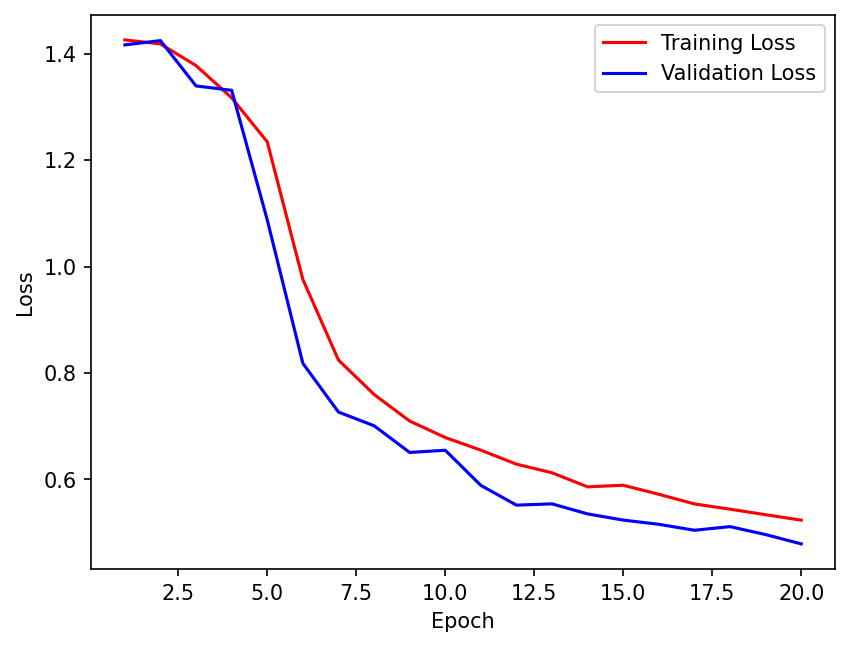

In [16]:
#Plot Training and Validation loss vs. Epoch
epoch=np.arange(1,21)
val_loss= [1.4165, 1.4245, 1.3394, 1.3312, 1.0877, 0.8182, 0.7267,0.7010, 0.6508, 0.6549,0.5889, 0.5518, 0.5542, 0.5353, 0.5237, 0.5158, 0.5046, 0.5114, 0.4965, 0.4790]
train_loss= [1.4259, 1.4183, 1.3776, 1.3171, 1.2344, 0.9759, 0.8245, 0.7598, 0.7098, 0.6789, 0.6551, 0.6288, 0.6126, 0.5862, 0.5892, 0.5722, 0.5541, 0.5442, 0.5338, 0.5236]

#plotting and garnishing
plt.figure(dpi=150)
plt.plot(epoch, train_loss, color='red', label='Training Loss')
plt.plot(epoch, val_loss, color='blue', label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

### After 20 epochs
- Loss: 0.5236
- Accuracy: 0.7992
- Validation loss: 0.4790
- Validation Accuracy: 0.8193

### Model is successful in learning to classify the galaxies into the 5 classes

Thus, we learn that CNNs are the most efficient at classifying images, with the highest accuracy on train and validation data